In [1]:
!pip install pertpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


(might have to uninstall and reinstall seaborn here)

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

from utils import annotate, scanpy_setup, ctrl_categories_setup
from utils import sample_and_merge_control, remove_groups, get_flat_df, normalize_per_metric
from utils import get_distance_per_perturbation, add_rank_col, compile_from_pwdfs
from analysis_utils import plot_volcano

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pertpy as pt

Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pyto

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

Load in a non-simulated dataset containing a relatively large variety of conditions within a single cell line.

In [30]:
adata = pt.data.dixit_2016()

We'll set up the dataset as we usually would with `scanpy`, and select a dataset-specific standardization of the `'perturbation'` column label + calculate leiden clusters so that we have 5 groups in the control condition.

In [31]:
# batch effect is severe in dixit so we subset to the cluster with more control cells
adata = adata[adata.obs.cluster == 'tfs_7']

In [32]:
scanpy_setup(adata)

In [33]:
adata.obs['perturbation'] = adata.obs.perturbation_name.values
ctrl_categories_setup(adata, resolution=.8)

0    934
1    931
2    682
3    581
4    538
5    353
6    350
7    106
Name: leiden, dtype: int64


In summary, our adata now looks like this.

In [34]:
adata

AnnData object with n_obs × n_vars = 31040 × 18531
    obs: 'cluster', 'guide', 'INTERGENIC1144056', 'INTERGENIC1216445', 'INTERGENIC216151', 'INTERGENIC393453', 'sgCREB1_2', 'sgCREB1_4', 'sgCREB1_5', 'sgE2F4_6', 'sgE2F4_7', 'sgEGR1_2', 'sgEGR1_3', 'sgEGR1_4', 'sgELF1_1', 'sgELF1_2', 'sgELF1_4', 'sgELF1_5', 'sgELK1_1', 'sgELK1_6', 'sgELK1_7', 'sgETS1_3', 'sgETS1_5', 'sgGABPA_1', 'sgGABPA_9', 'sgIRF1_2', 'sgIRF1_3', 'sgNR2C2_2', 'sgNR2C2_3', 'sgNR2C2_5', 'sgYY1_10', 'sgYY1_3', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit', 'perturbation'
    var: 'index', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'doi', 'hvg', 'leiden', 'neighbors', 'pca', 'preprocessing_nb_link', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    

### sanity checks

Similar to what we did for simulated data, plot what these real perturbations look like.

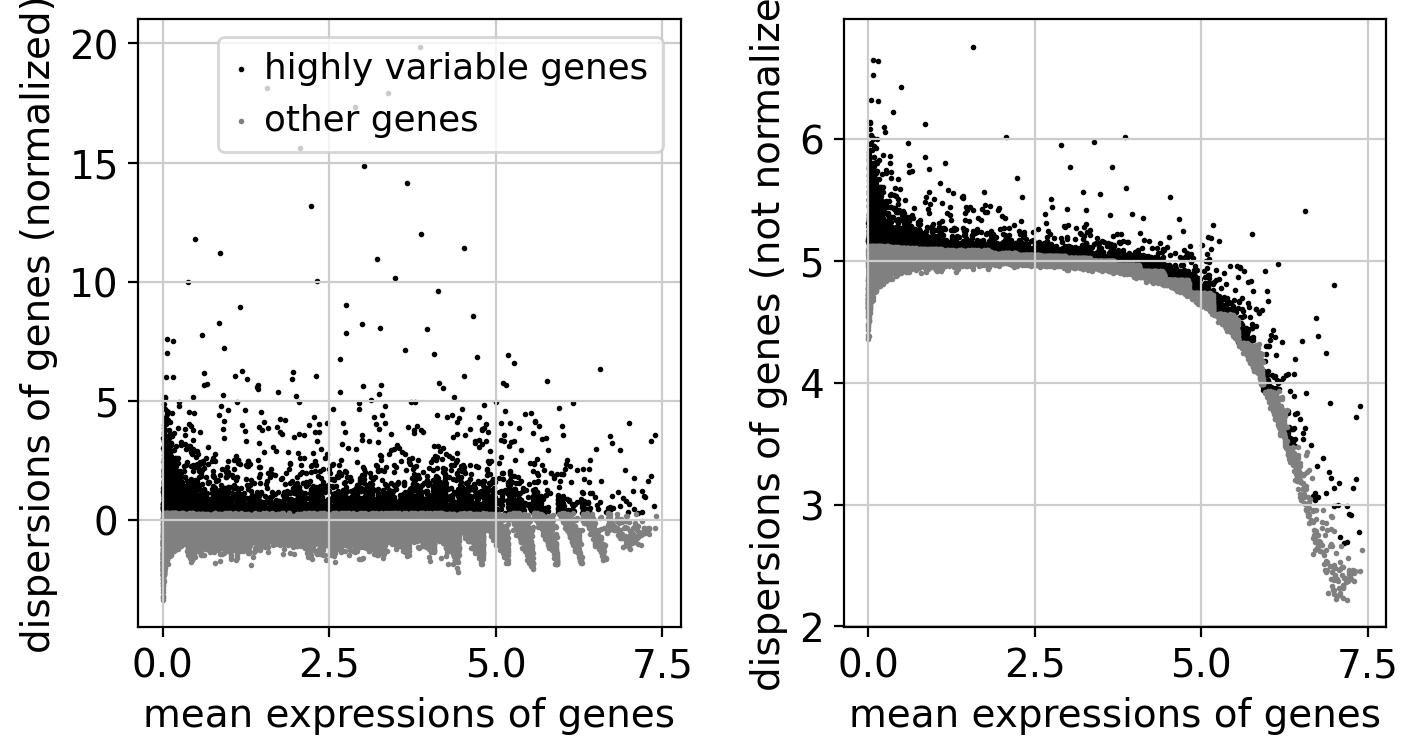

In [36]:
sc.pl.highly_variable_genes(adata)

In [37]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

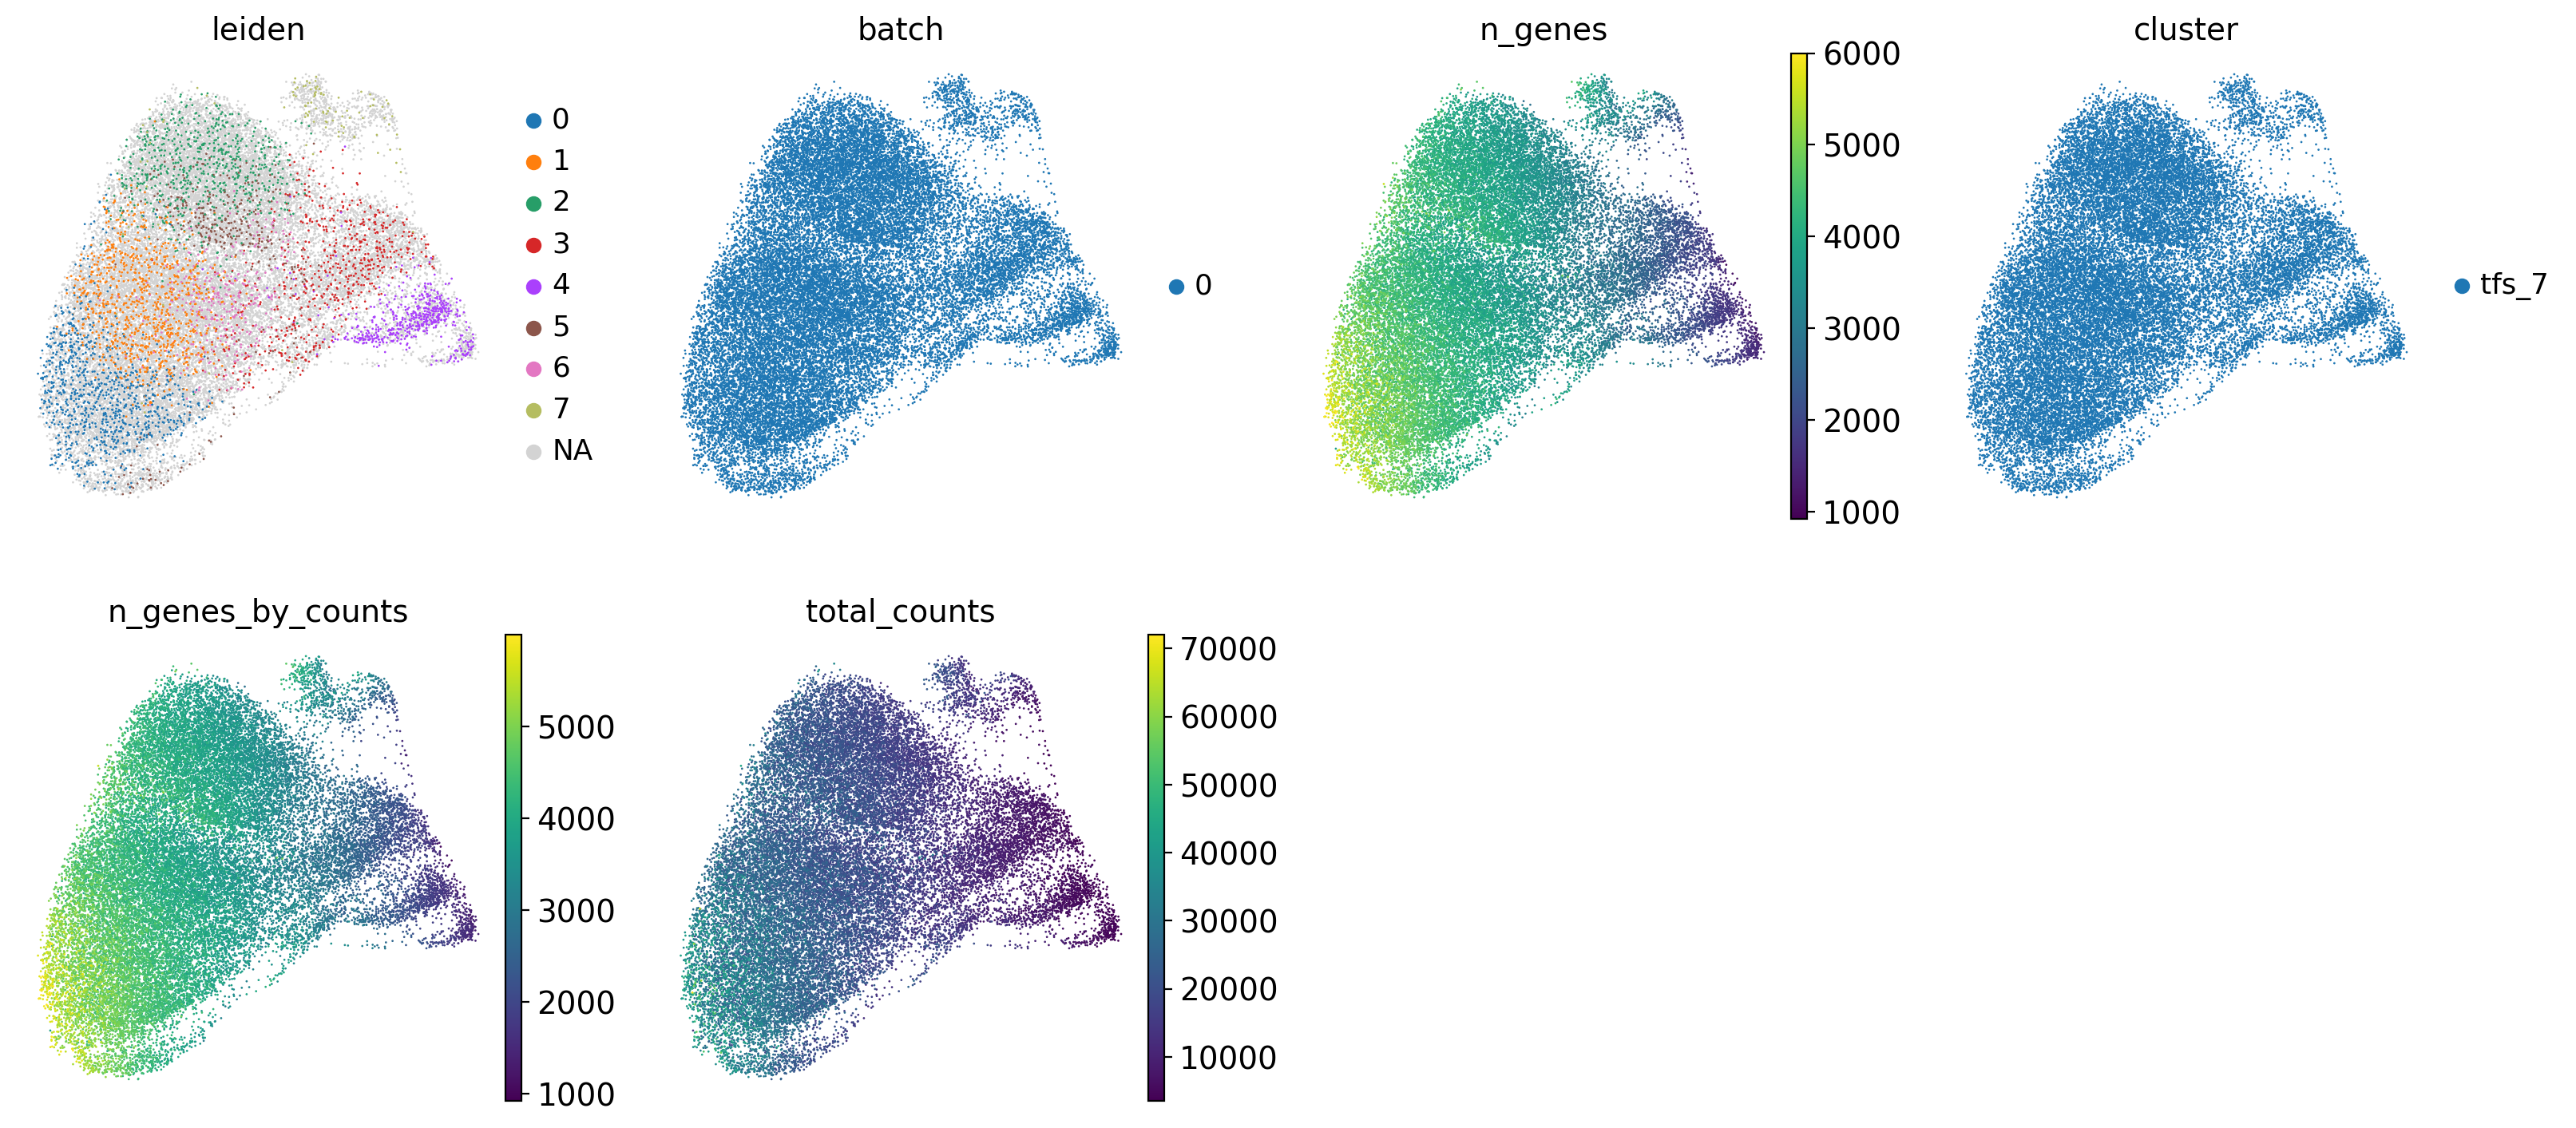

In [38]:
sc.pl.umap(adata, color=['leiden', 'batch', 'n_genes', 'cluster', 'n_genes_by_counts', 'total_counts'], ncols=4)

To make sure the rest of the plots make sense, let's look at the distribution of treatments.

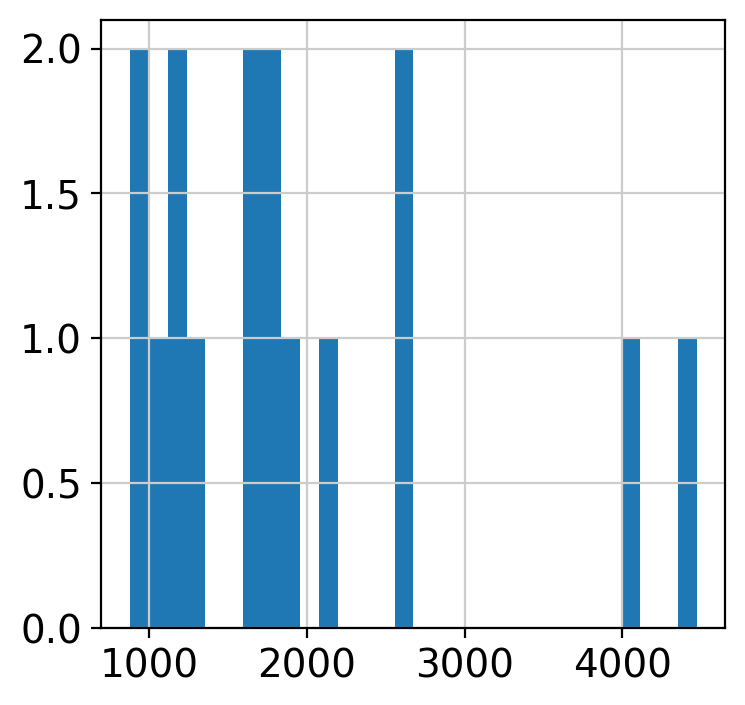

In [39]:
plt.hist(adata.obs.perturbation.value_counts().values, bins=30);

## run metrics for different numbers of cells

We'll set up the adata similarly. However, this time the total number of cells will be given to us by the actual total number of cells for a condition in the dataset.

In [40]:
merged = sample_and_merge_control(adata, adata[adata.obs.perturbation == 'control'], n=5)

filtered = remove_groups(merged, min_cells=40)

Now that we have a filtered adata, we will calculate the number of differentially expressed genes per condition to use as a plotting parameter and baseline metric, in addition to getting pairwise distances dataframes for each metric. We'll use a classic volcano plot with threshold for counting the number of differentially expressed genes.

In [41]:
sc.tl.rank_genes_groups(filtered, groupby='perturbation', reference='control')

In [44]:
ndegs = {}
for p in filtered.obs.perturbation.unique():
    if p == 'control':
        continue
        
    _, up, dn = plot_volcano(sc.get.rank_genes_groups_df(filtered, group=p), fc_thresh=.3, logpval_thresh=30, plot=False)
    ndegs[p] = len(up) + len(dn)

ndegs['control'] = 0

To speed the pairwise distance calculation up, we'll remove the large control condition.

In [45]:
no_ctrl = filtered[filtered.obs.perturbation != 'control']

In [46]:
controls = ['control0', 'control1', 'control2', 'control3', 'control4']
metrics = ["edistance",'pseudobulk','mmd'] #wasserstein

pwdfs = {}

for metric in metrics:
    distance = pt.tools.Distance(metric=metric)
    pairwise_df = distance.pairwise(no_ctrl, groupby='perturbation')

    pwdfs[metric + '_dixit'] = pairwise_df  # TODO: this is where you would add additional datasets

Output()

Output()

Output()

Concatenate the individual melted distance dataframes and label with the following metadata:
- number of DEGs
- rank according to the first metric
- whether it is control or perturbation
- number of cells in the condition

In [53]:
df = compile_from_pwdfs(filtered, pwdfs, metrics, controls, ndegs)

control: 31.758853149414062
control: 37.14102840423584
control: 1619.3340759277344


Calculate and visualize change in distance due to sample size.

In [54]:
normed_df = normalize_per_metric(df, label='distance')

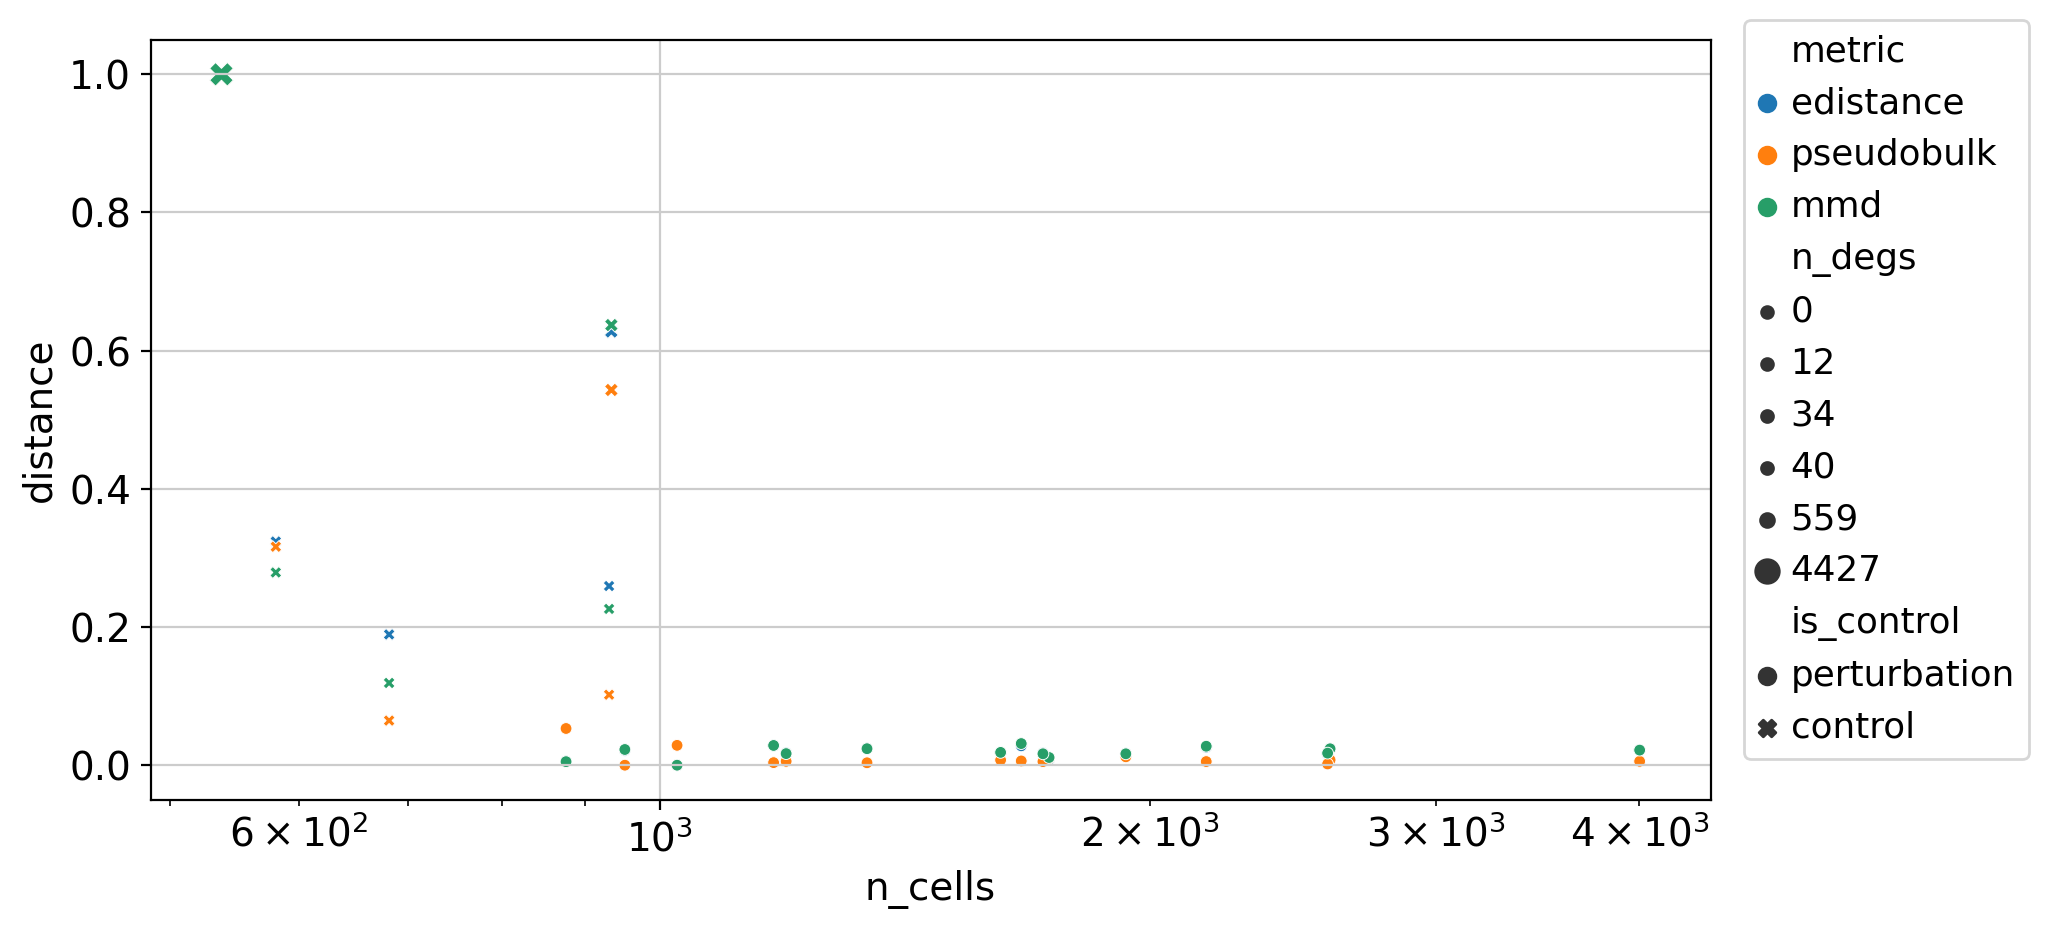

In [55]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=normed_df, x='n_cells', y='distance', hue='metric', size='n_degs', style='is_control')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1.05))

## run metrics for different numbers of features

How does the number of HVGs selected impact these metrics? We'll also look at whether the different flavors of HVG selection offered by `scanpy` matter here.

In [61]:
adata

AnnData object with n_obs × n_vars = 31040 × 18531
    obs: 'cluster', 'guide', 'INTERGENIC1144056', 'INTERGENIC1216445', 'INTERGENIC216151', 'INTERGENIC393453', 'sgCREB1_2', 'sgCREB1_4', 'sgCREB1_5', 'sgE2F4_6', 'sgE2F4_7', 'sgEGR1_2', 'sgEGR1_3', 'sgEGR1_4', 'sgELF1_1', 'sgELF1_2', 'sgELF1_4', 'sgELF1_5', 'sgELK1_1', 'sgELK1_6', 'sgELK1_7', 'sgETS1_3', 'sgETS1_5', 'sgGABPA_1', 'sgGABPA_9', 'sgIRF1_2', 'sgIRF1_3', 'sgNR2C2_2', 'sgNR2C2_3', 'sgNR2C2_5', 'sgYY1_10', 'sgYY1_3', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit', 'perturbation'
    var: 'index', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'doi', 'hvg', 'leiden', 'neighbors', 'pca', 'preprocessing_nb_link', 'umap', 'log1p', 'leiden_colors', 'batch_colors', 'cluster_color

We'll select the HVGs from the original 10k, while including all conditions, including those that might not have enough cells.

In [62]:
experiment_condi = [10, 50, 100, 500, 1000, 5000]  # number of HVGs

feature_subsets = {}
for n in experiment_condi:
    sc.pp.highly_variable_genes(adata, n_top_genes=n, flavor='seurat')
    feature_subsets[n] = list(adata.var_names[adata.var['highly_variable']])

We'll still use the original 5 control conditions to average over so that we get a distribution of metric values. We filter for conditions with a minimum of 300 cells, which we see from the above plot has a reasonable amount of variance in the metric. 

In [ ]:
no_ctrl = remove_groups(no_ctrl, min_cells=300)

In [69]:
no_ctrl.obs.perturbation.value_counts()  # need to fix why controls aren't sampled haha

ELF1                 4001
ELK1                 2582
CREB1                2573
EGR1                 2167
GABPA                1934
INTERGENIC393453     1735
NR2C2                1720
ETS1                 1668
E2F4                 1620
IRF1                 1341
INTERGENIC216151     1196
INTERGENIC1144056    1175
YY1                  1025
INTERGENIC1216445     952
control0              934
control1              931
YY10                  876
control2              682
control3              581
control4              538
Name: perturbation, dtype: int64

Calculate metrics for each perturbation.

In [72]:
# globals, delete in future
controls = ['control0', 'control1', 'control2', 'control3', 'control4']
metrics = ["edistance", 'pseudobulk', 'mmd'] #'wasserstein']

In [73]:
pwdfs = {}
ctrls = {}
for n, features in feature_subsets.items():
    subset = no_ctrl[:, features]
    ## because some metrics run on PCA space, we also have to rerun PCA here
    sc.pp.pca(subset, use_highly_variable=False)  # uses all genes
    
    for metric in metrics:
        print(metric)

        distance = pt.tools.Distance(metric=metric)
        pwdf = distance.pairwise(subset, groupby='perturbation')
        
        pwdfs[metric + '_' + str(n)] = pwdf
        
        ## Get average distance of control to control (exclude diagonal) ##
        ctrl_ctrl = pwdf.loc[controls, controls]
        ctrl_dist = ctrl_ctrl.sum().sum() / (25 - 5) 
        ctrls[metric + '_' + str(n)] = ctrl_dist

        print("control:", ctrl_dist)

Output()

edistance


Output()

control: 31.758853149414062
pseudobulk


Output()

control: 0.7270267575979232
mmd


control: 0.5911022506654262


Output()

edistance


Output()

control: 31.758853149414062
pseudobulk


control: 3.410737955570221
mmd


Output()

control: 12.727378225326538


Output()

edistance


Output()

control: 31.758853149414062
pseudobulk


control: 5.306411600112915
mmd


Output()

control: 30.056386089324953


Output()

edistance


Output()

control: 31.758853149414062
pseudobulk


control: 11.36918249130249
mmd


Output()

control: 140.47280006408693


Output()

edistance


Output()

control: 31.758853149414062
pseudobulk


control: 15.821058177947998
mmd


Output()

control: 274.5570755004883


Output()

edistance


Output()

control: 31.758853149414062
pseudobulk


Output()

control: 37.146059608459474
mmd


control: 1619.6711364746093


In [83]:
melted_df = get_flat_df(pwdfs, controls, label='n_genes')

Text(0, 0.5, 'relative ave dist')

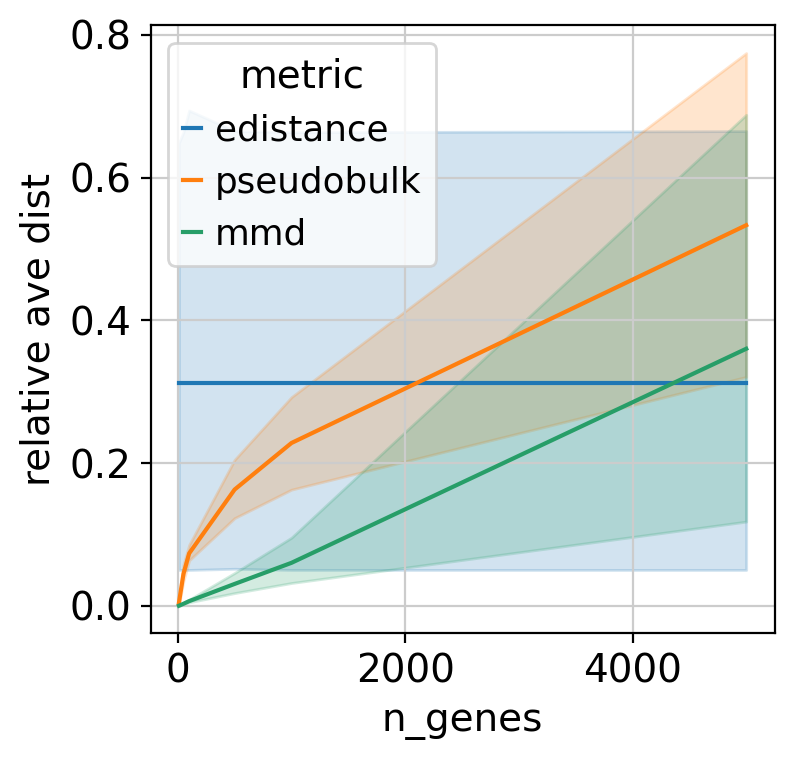

In [84]:
sns.lineplot(data=normalize_per_metric(melted_df), x='n_genes', y='avg_dist', hue='metric')
plt.ylabel('relative ave dist')

## run metrics for different percentages of mislabeled cells, representing a typical CRISPR experiment

Set skew to .01 as well?

## sparsity

How does library size/sparsity affect these metrics?

In [378]:
log_library_sizes = np.array(range(83, 94, 2))/10

This one is a bit different from the above, as we load in several adatas.

In [379]:
# global settings
controls = ['control0', 'control1']# , 'control2', 'control3', 'control4']
metrics = ["edistance",'pseudobulk','mmd'] #wasserstein

In [380]:
adatas = {}
for libsize in log_library_sizes:
    a = ad.AnnData(pd.read_csv(f'../{libsize}-sparsity_sim.csv').T, obs=pd.read_csv(f'../{libsize}-sparsity_sim_obs.csv'))
    a.obs['libsize'] = libsize
    
    ## setup functions above
    annotate(a, pd.read_csv(f'../{libsize}-sparsity_sim_params.csv'))
    scanpy_setup(a)
    ctrl_categories_setup(a, resolution=.75)

    adatas[libsize] = a

0    1916
1    1831
2    1226
3     717
4     350
Name: leiden, dtype: int64
0    2094
1    2055
2     860
3     749
4     282
Name: leiden, dtype: int64
0    2087
1    1960
2    1257
3     736
Name: leiden, dtype: int64
0    1973
1    1952
2    1142
3     540
4     433
Name: leiden, dtype: int64
0    2154
1    2020
2    1604
3     262
Name: leiden, dtype: int64
0    2343
1    1644
2    1452
3     601
Name: leiden, dtype: int64


Set the number of cells per condition to 700 (stable) and calculate the distance for each perturbation, per metric per adata.

In [381]:
distance_dfs = {}
for libsize, a in adatas.items():
    print(libsize)
    ## get distance dfs for the set of perturbations in each adata
    ncell = 700
    merged = sample_and_merge_control(a, a[a.obs.perturbation == 'control'], n=3)
    filtered = subsample(remove_groups(merged, min_cells=40), ncell)
    filtered.obs_names_make_unique()

    pwdfs = {}
    for metric in metrics:
        subset = generate(ncell, filtered, min_cells=ncell)

        distance = pt.tools.Distance(metric=metric)
        pairwise_df = distance.pairwise(subset, groupby='perturbation')

        pwdfs[metric + '_' + str(ncell)] = pairwise_df
    
    ## calculate control cutoff
    dfs, _ = get_distance_per_perturbation(pwdfs, n=ncell)  # TODO why is this line still returning controls
    # concatenate dfs
    df = pd.concat(dfs).reset_index()
    df.columns = ['perturbation', 'distance', 'metric']
    
    add_rank_col(df, dfs[0])
    
    distance_dfs[libsize] = df

8.3


Output()

Output()

Output()

control: 0.2966827392578125
control: 1.0564582824707032
control: 11.161041259765625
8.5


Output()

Output()

Output()

control: 0.31898651123046873
control: 1.0844274520874024
control: 11.759829711914062
8.7


Output()

Output()

Output()

control: 0.3088981628417969
control: 1.059555435180664
control: 11.226577758789062
8.9


Output()

Output()

Output()

control: 0.3720958709716797
control: 1.1546236991882324
control: 13.331559753417968
9.1


Output()

Output()

Output()

control: 0.3440380096435547
control: 1.0959697723388673
control: 12.011498260498048
9.3


Output()

Output()

Output()

control: 0.32176513671875
control: 1.0408083915710449
control: 10.83282012939453


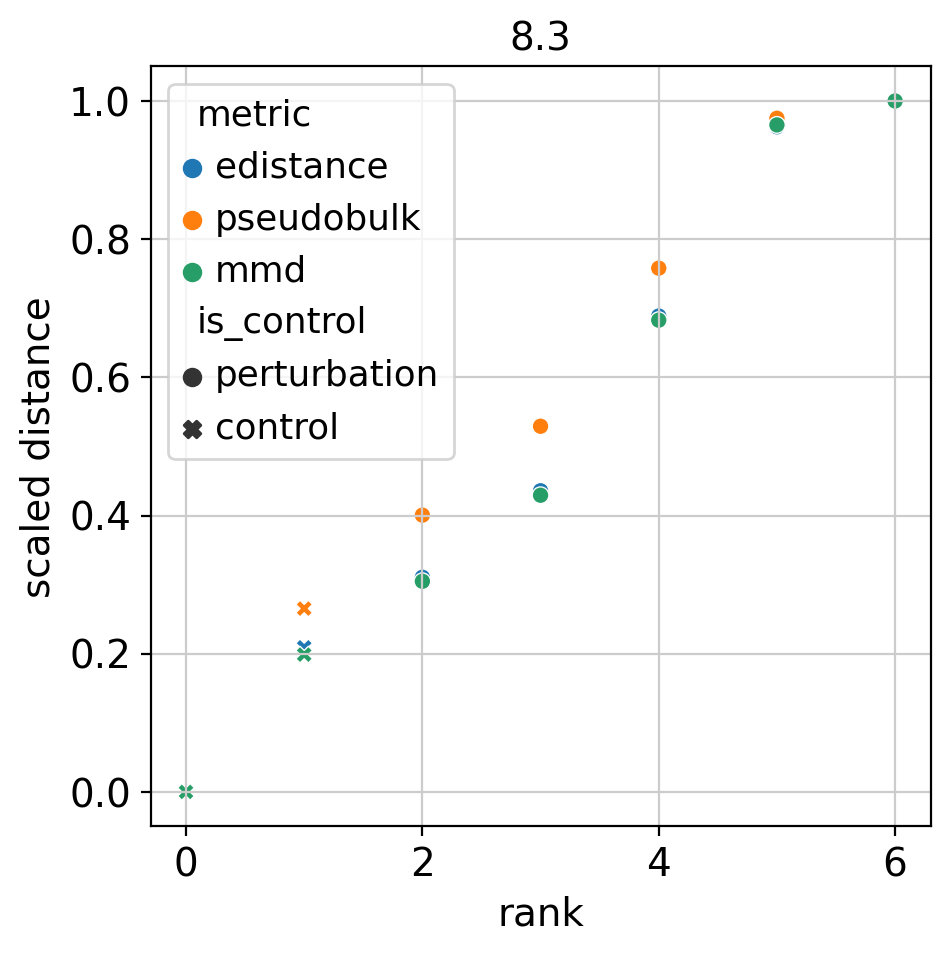

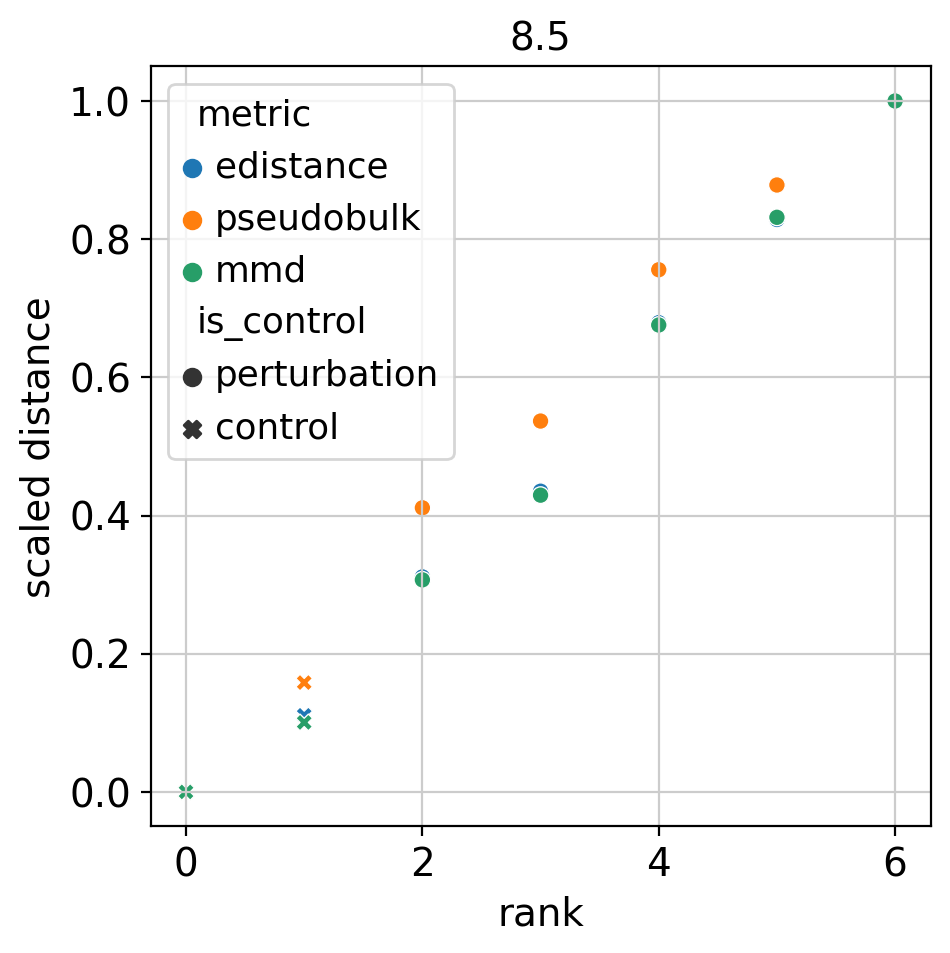

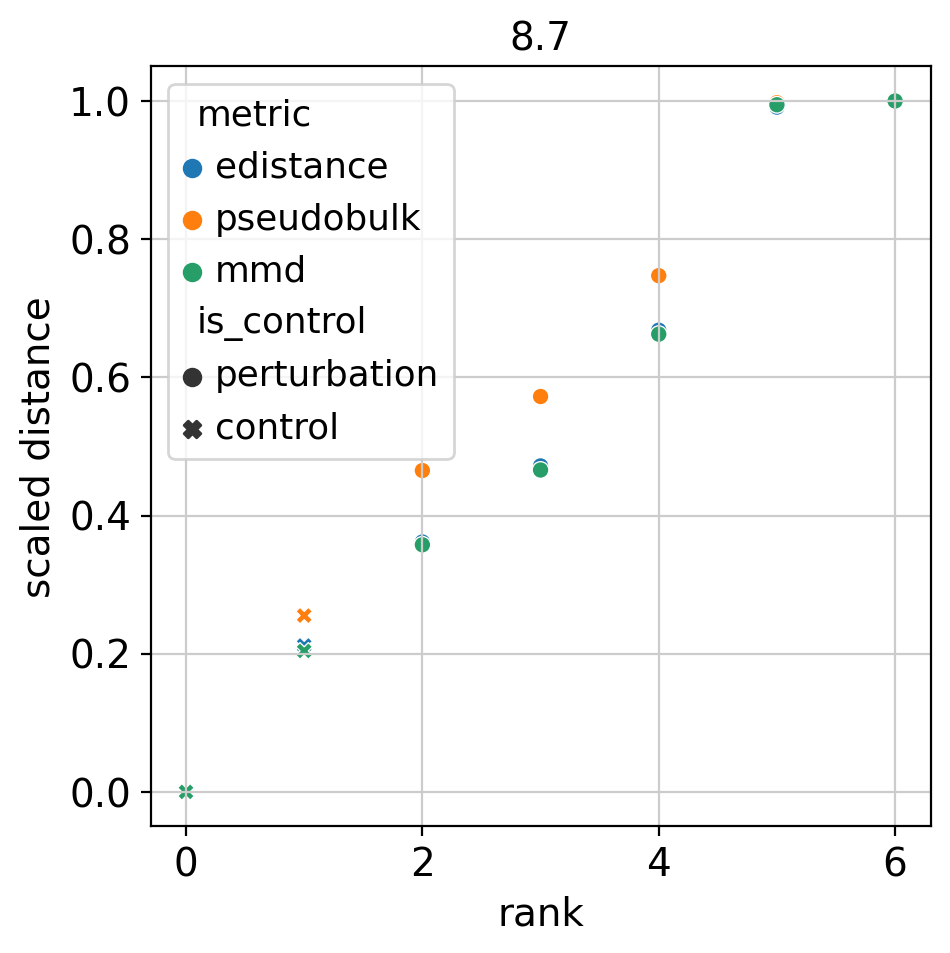

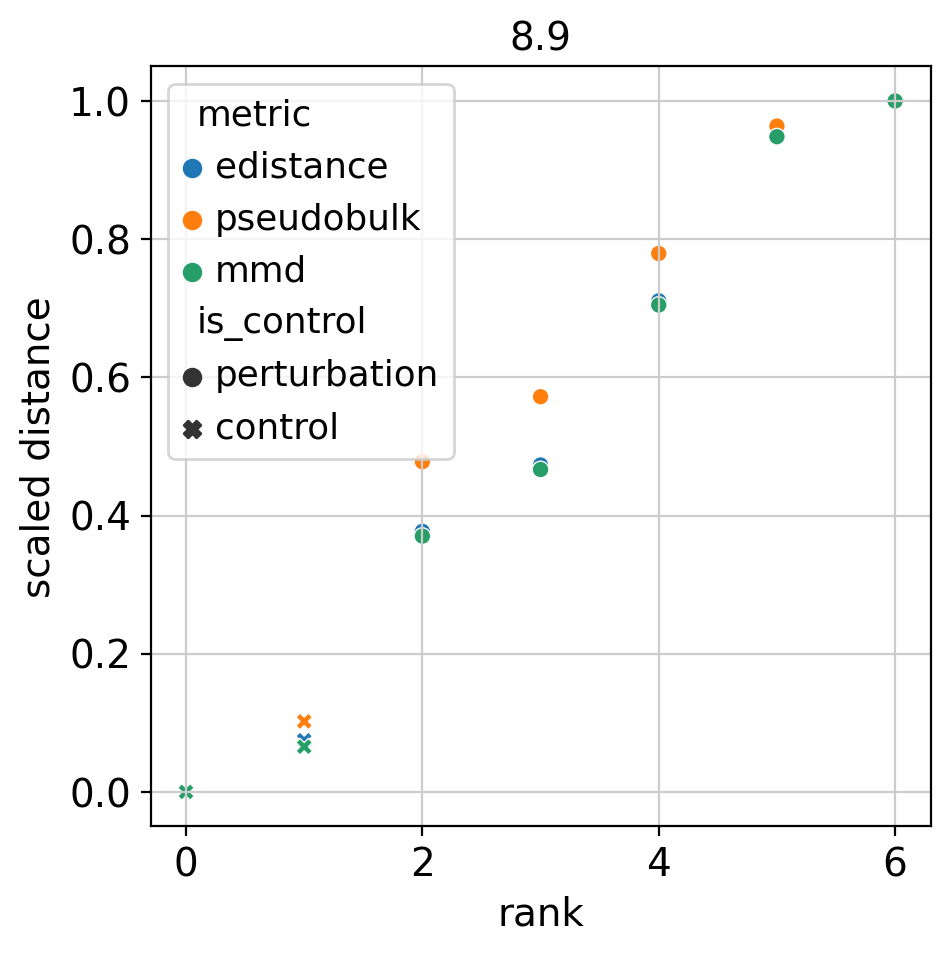

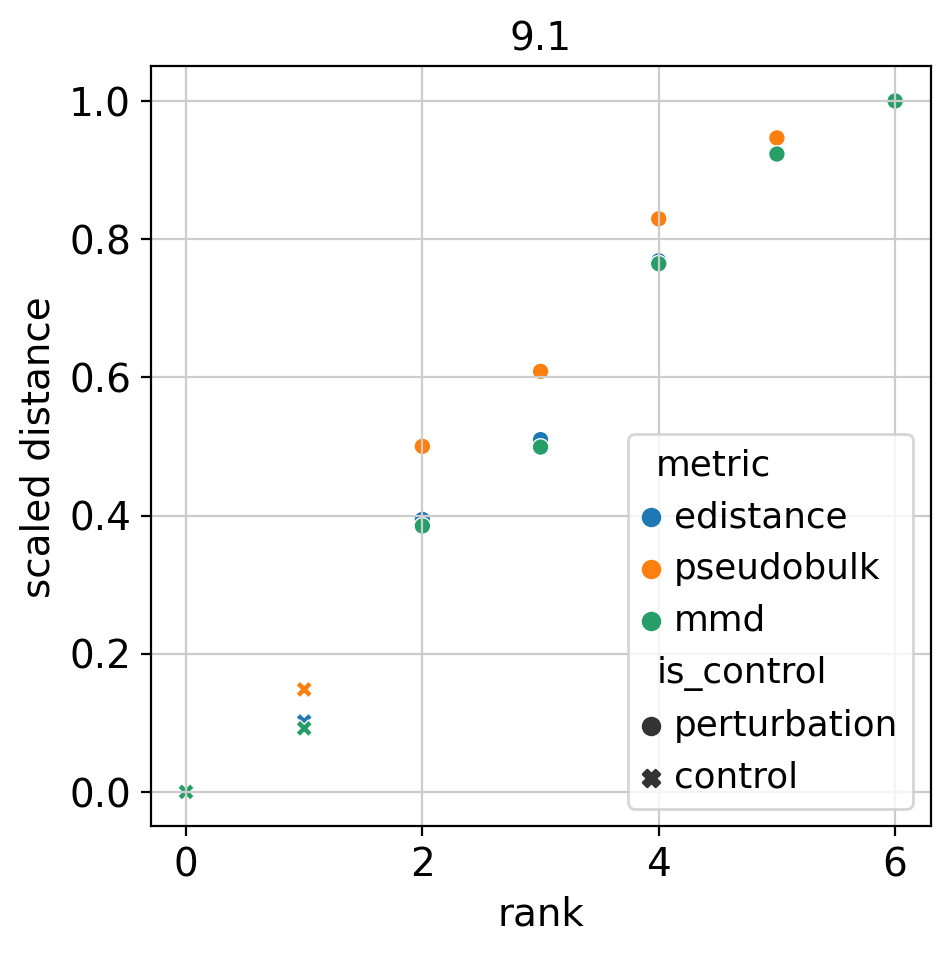

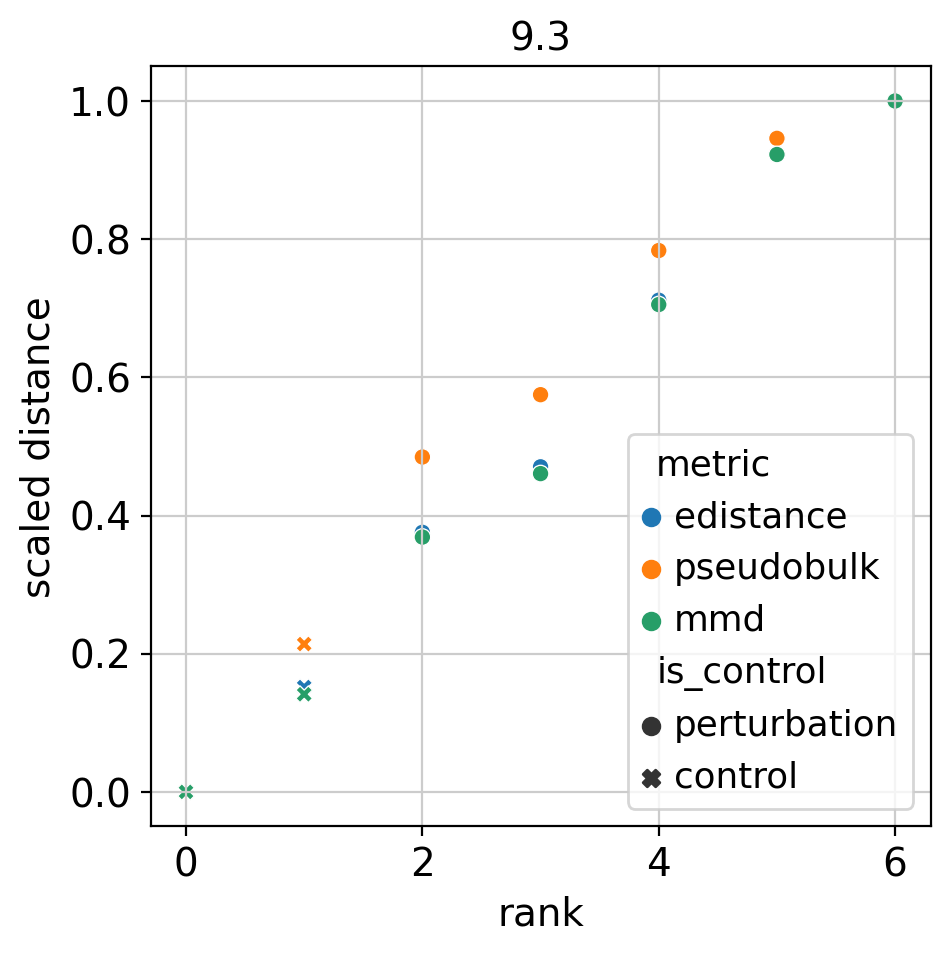

In [382]:
for libsize, df in distance_dfs.items():    
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=normalize_per_metric(df, label='distance'), x='rank', y='distance', hue='metric', style='is_control')
    # for i, row in normed_df[normed_df.perturbation == 'control'].iterrows():
    #     plt.axhline(row['distance'], label=row['metric'])
    plt.ylabel('scaled distance')
    plt.title(libsize)
    plt.show()